In [53]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [54]:
import sys
LOCAL_FAST_AI = '/Users/krishnakalyan3/Educational/FastAI/fastai/'
AWS_FAST_AI = '/home/ubuntu/fastai'
sys.path.append(AWS_FAST_AI)

In [55]:
from fastai.transforms import * 
from fastai.conv_learner import * 
from fastai.model import *
from fastai.dataset import * 
from fastai.sgdr import *
from fastai.plots import *

In [56]:
PATH = '/home/ubuntu/Plant/data_all/'

In [57]:
label_csv = f'{PATH}all.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n, val_pct=.20)
n, len(val_idxs)

(5544, 1108)

In [58]:
f_model = resnet50
sz=250
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)

In [59]:
data = ImageClassifierData.from_csv(PATH, folder='all_train', csv_fname=f'{PATH}all.csv',
                                    tfms=tfms, val_idxs=val_idxs, test_name='test',  bs=64)

In [60]:
learn = ConvLearner.pretrained(f_model, data, precompute=True)
learn.models.model = torch.nn.DataParallel(learn.models.model,device_ids=list(range(0,8)))

100%|██████████| 18/18 [00:12<00:00,  1.47it/s]


In [61]:
learn.precompute=False
lr = 1e-1
learn.fit(lr, 3, cycle_len=1)

A Jupyter Widget

epoch      trn_loss   val_loss   <lambda>                  
    0      0.362697   0.188608   0.971213  
    1      0.165407   0.087126   0.97084                   
    2      0.111804   0.07368    0.97464                   



[0.073680453, 0.97463991244633996]

In [62]:
learn.unfreeze()
lr=np.array([lr/18,lr/6,lr/2])
learn.fit(lr, 3, cycle_len=2, cycle_mult=2)

A Jupyter Widget

epoch      trn_loss   val_loss   <lambda>                   
    0      0.099397   0.076601   0.972621  
    1      0.091033   0.069658   0.976241                   
    2      0.081897   0.063747   0.976112                   
    3      0.082546   0.058943   0.978562                   
    4      0.078267   0.055298   0.979752                   
    5      0.073417   0.057148   0.978492                   
    6      0.074029   0.073976   0.972833                   
    7      0.07547    0.077104   0.972113                   
    8      0.085987   0.057699   0.978614                   
    9      0.077271   0.05264    0.979951                   
    10     0.072532   0.052074   0.980292                   
    11     0.074565   0.051871   0.980478                   
    12     0.072687   0.051245   0.980536                   
    13     0.070677   0.05054    0.980613                   



[0.050540373, 0.98061343034108484]

In [64]:
preds,y = learn.TTA()
mean_logpreds = np.mean(preds, 0)
max_preds = np.argmax(mean_logpreds, 1)

In [70]:
y = np.argmax(y, 1)

In [71]:
def metrics(y, yhat, plot=False):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import f1_score
    from sklearn.metrics import accuracy_score
    import matplotlib.pyplot as plt

    cm = confusion_matrix(y, yhat)
    f1 = f1_score(y, yhat, average='macro')
    acc = accuracy_score(y, yhat)

    if plot:
        plt.matshow(cm)
    return f1, acc, cm

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(0.5110853766604031,
 0.80324909747292417,
 array([[ 45,   0,   0,   0,   0,   0,   5,   0,   0,   1,   0,  14,   0,   0,   0,   0,   0,   0,   0,   0,
           1],
        [  0,  94,   0,   1,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0],
        [  0,   0,   0,   0,   1,  15,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0],
        [  0,   0,   0,  58,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   2,   0,   0,   0,
           0],
        [  0,   0,   0,   0,   0,   0,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0],
        [  0,   0,   0,   1,   0, 105,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   2,   0,   0,   0,
           0],
        [  1,   1,   0,   0,   0,   1,  45,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           1],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 

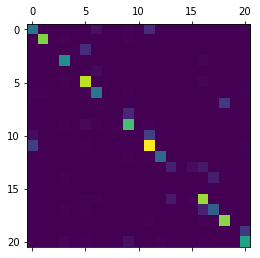

In [72]:
metrics(y, max_preds, True)

In [51]:
learn.save(f'resnet_50_all_{sz}')

In [50]:
log_preds_test = learn.predict(is_test=True)
max_preds = np.argmax(log_preds_test, 1)

In [52]:
preds_classes = [data.classes[i].replace("_", " ") for i in max_preds]
submission = pd.DataFrame({'file': os.listdir(f'{PATH}test'), 'species': preds_classes})
submission.to_csv(PATH + 'submission_resnet_50_all.csv', index=False)